# Challenge: Optimization on Other Datasets

## Download data from `yfinance`

In [1]:
import yfinance as yf

ticker = 'ZM'
df = yf.download(ticker)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-18,65.000000,66.000000,60.320999,62.000000,62.000000,25764700
2019-04-22,61.000000,68.900002,59.939999,65.699997,65.699997,9949700
...,...,...,...,...,...,...
2023-05-11,64.730003,65.050003,63.720001,64.449997,64.449997,2344200
2023-05-12,64.410004,64.410004,63.290001,63.689999,63.689999,2652900


## Preprocess the data

### Filter the date range

- Since 1 year ago at least

In [2]:
df = df.loc['2020-01-01':].copy()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,68.800003,69.235001,68.019997,68.720001,68.720001,1315500
2020-01-03,67.620003,68.680000,67.099998,67.279999,67.279999,1127900
...,...,...,...,...,...,...
2023-05-11,64.730003,65.050003,63.720001,64.449997,64.449997,2344200
2023-05-12,64.410004,64.410004,63.290001,63.689999,63.689999,2652900


### Create the target variable

#### Percentage change

- Percentage change on `Adj Close` for tomorrow

In [3]:
df['change_tomorrow'] = df['Adj Close'].pct_change(-1)
df.change_tomorrow = df.change_tomorrow * -1
df.change_tomorrow = df.change_tomorrow * 100
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,68.800003,69.235001,68.019997,68.720001,68.720001,1315500,-2.140313
2020-01-03,67.620003,68.680000,67.099998,67.279999,67.279999,1127900,4.323096
...,...,...,...,...,...,...,...
2023-05-11,64.730003,65.050003,63.720001,64.449997,64.449997,2344200,-1.193277
2023-05-12,64.410004,64.410004,63.290001,63.689999,63.689999,2652900,NaN


#### Remove rows with any missing data

In [4]:
df = df.dropna().copy()
df

,Open,High,Low,Close,Adj Close,Volume,change_tomorrow
Date,,,,,,,
2020-01-02,68.800003,69.235001,68.019997,68.720001,68.720001,1315500,-2.140313
2020-01-03,67.620003,68.680000,67.099998,67.279999,67.279999,1127900,4.323096
...,...,...,...,...,...,...,...
2023-05-10,64.139999,65.669998,64.050003,64.430000,64.430000,3533400,0.031027
2023-05-11,64.730003,65.050003,63.720001,64.449997,64.449997,2344200,-1.193277


## Compute Machine Learning model

Proposal: Random Forest within `ensemble` module of `sklearn` library

In [5]:
from sklearn.ensemble import RandomForestRegressor

In [6]:
model = RandomForestRegressor(max_depth=20, random_state=42)

In [7]:
y = df.change_tomorrow
X = df.drop(columns='change_tomorrow')

In [8]:
model.fit(X, y)

RandomForestRegressor(max_depth=20, random_state=42)

In [9]:
model.score(X, y)

0.812164540151536

## Parametrize & optimize the investment strategy

### Create Strategy class

In [10]:
from backtesting import Strategy

In [11]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create `Backtest` class

In [12]:
from backtesting import Backtest

In [13]:
bt = Backtest(
    X, Regression, cash=10000,
    commission=.002, exclusive_orders=True
)

### Optimize backtesting with multiple combinations

In [14]:
stats_skopt, heatmap, optimize_result = bt.optimize(
    limit_buy=[0, 10],
    limit_sell=[-10, 0],
    maximize='Return [%]',
    method='skopt',
    max_tries=500,
    random_state=0,
    return_heatmap=True,
    return_optimization=True)

### Which are the best values for the parameters?

In [15]:
import numpy as np

In [16]:
dff = heatmap.reset_index()
dff = dff.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')

dff.sort_index(axis=1, ascending=False)\
    .style.format(precision=0)\
    .background_gradient(vmin=np.nanmin(dff), vmax=np.nanmax(dff))\
    .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,2853978772,nan,19741604,nan,nan,nan,nan,nan,nan,93,nan
1,nan,nan,15477884,nan,nan,1762,nan,127,nan,nan,nan
2,nan,nan,5015417,nan,48633,nan,964,nan,nan,nan,nan
3,nan,87712,nan,125997,nan,nan,nan,nan,518,nan,nan
4,nan,nan,32349,13263,nan,nan,nan,nan,nan,nan,145
5,222,169,nan,nan,nan,81,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,nan,nan,1106,nan
7,-99,nan,nan,nan,nan,nan,nan,538,nan,918,nan
8,nan,nan,nan,-100,nan,-100,538,nan,nan,nan,nan


### How to interpret smart optimization?

#### Number of evaluations

https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html

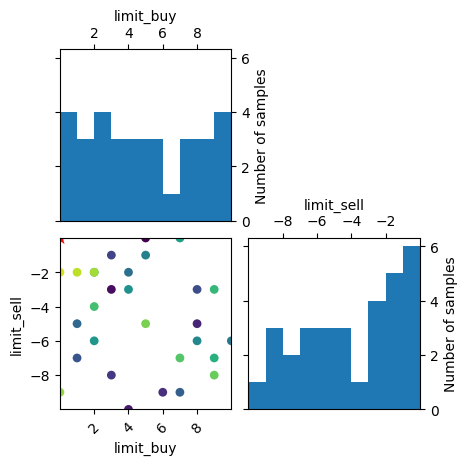

In [17]:
from skopt.plots import plot_evaluations

_ = plot_evaluations(optimize_result, bins=10)

#### Density

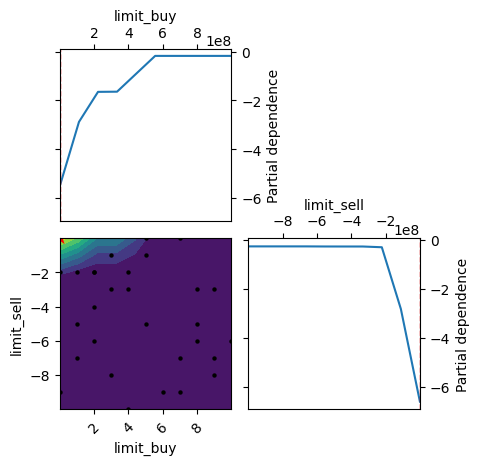

In [18]:
from skopt.plots import plot_objective

_ = plot_objective(optimize_result, n_points=10)

## Continue with the tutorials on the following chapter

> Backtest the investment strategy on a validation set.

Next chapter → [The Overfitting Problem in Backtesting]()

![](<src/09_Table_The Overfitting.png>)